# Selecting data & finding the most common complaint type

## Install

In [1]:
SYFT_VERSION = ">=0.8.1b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
!pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html -q

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

✅ The installed version of syft==0.8.1b2 matches the requirement >=0.8.1b0 and the requirement <0.9


In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-1", port=8080, reset=True)

Starting pandas-test-domain-1 server on 0.0.0.0:8080
SQLite Store Path:
!open file:///var/folders/6_/7xx0tpq16h9cn40mq4w5gjk80000gn/T/e6511c55456b4ad7844f04d2985660cb.sqlite



# Data Owner: Upload data

In [4]:
domain_client = node.login(email="info@openmined.org", password="changethis")

In [5]:
from syft.serde.mock import CachedFaker
from random import randint
from syft.util.util import PANDAS_DATA
from syft.service.project.project import Project
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (15, 5)

## Load data

We're going to use a new dataset here, to demonstrate how to deal with larger datasets. This is a subset of the of 311 service requests from NYC Open Data.

In [7]:
# because of mixed types we specify dtype to prevent any errors
complaints = pd.read_csv(sy.autocache(f"{PANDAS_DATA}/311-service-requests.csv"), dtype='unicode')

Depending on your pandas version, you might see an error like "DtypeWarning: Columns (8) have mixed types". This means that it's encountered a problem reading in our data. In this case it almost certainly means that it has columns where some of the entries are strings and some are integers.

For now we're going to ignore it and hope we don't run into a problem, but in the long run we'd need to investigate this warning.

In [8]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,26589651,10/31/2013 02:08:41 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11432,90-03 169 STREET,169 STREET,90 AVENUE,91 AVENUE,NaN,NaN,ADDRESS,JAMAICA,NaN,Precinct,Assigned,10/31/2013 10:08:41 AM,10/31/2013 02:35:17 AM,12 QUEENS,QUEENS,1042027,197389,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.70827532593202,-73.79160395779721,"(40.70827532593202, -73.79160395779721)"
1,26593698,10/31/2013 02:01:04 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,11378,58 AVENUE,58 AVENUE,58 PLACE,59 STREET,NaN,NaN,BLOCKFACE,MASPETH,NaN,Precinct,Open,10/31/2013 10:01:04 AM,NaN,05 QUEENS,QUEENS,1009349,201984,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.721040535628305,-73.90945306791765,"(40.721040535628305, -73.90945306791765)"
2,26594139,10/31/2013 02:00:24 AM,10/31/2013 02:40:32 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10032,4060 BROADWAY,BROADWAY,WEST 171 STREET,WEST 172 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,10/31/2013 10:00:24 AM,10/31/2013 02:39:42 AM,12 MANHATTAN,MANHATTAN,1001088,246531,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.84332975466513,-73.93914371913482,"(40.84332975466513, -73.93914371913482)"
3,26595721,10/31/2013 01:56:23 AM,10/31/2013 02:21:48 AM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,10023,WEST 72 STREET,WEST 72 STREET,COLUMBUS AVENUE,AMSTERDAM AVENUE,NaN,NaN,BLOCKFACE,NEW YORK,NaN,Precinct,Closed,10/31/2013 09:56:23 AM,10/31/2013 02:21:10 AM,07 MANHATTAN,MANHATTAN,989730,222727,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.7780087446372,-73.98021349023975,"(40.7780087446372, -73.98021349023975)"
4,26590930,10/31/2013 01:53:44 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,Vacant Lot,10027,WEST 124 STREET,WEST 124 STREET,LENOX AVENUE,ADAM CLAYTON POWELL JR BOULEVARD,NaN,NaN,BLOCKFACE,NEW YORK,NaN,NaN,Pending,11/30/2013 01:53:44 AM,10/31/2013 01:59:54 AM,10 MANHATTAN,MANHATTAN,998815,233545,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.80769092704951,-73.94738703491433,"(40.80769092704951, -73.94738703491433)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111064,26426013,10/04/2013 12:01:13 AM,10/07/2013 04:07:16 PM,DPR,Department of Parks and Recreation,Maintenance or

## Create Mock data

Let's create the mock data for the complaint dataset.

In [9]:
fake = CachedFaker()

In [10]:
fake_functions = {
    "Unique Key": lambda x: randint(1,1000000),
    "Location": lambda x: (fake.coordinate(), fake.coordinate()),
    "Agency": lambda x: random.choice(["NYPD", "DOHMH", "DPR"]),
    "X Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Y Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Complaint Type": lambda x: random.choice(["Illegal Parking", "Noise - Street/Sidewalk", "'Animal in a Park'"]),
    "Descriptor": lambda x: random.choice([ 'Branch or Limb Has Fallen Down','Branches Damaged','Broken Fence', 'Broken Glass']),
    "School Number": lambda x: random.choice([ 'B073', 'B077', 'B079', 'B080-01', 'B087', 'B099', 'B100', 'B102', 'B109', 'B111']),
    "Bridge Highway Segment": lambda x: random.choice([ 'Grand Central Pkwy (Exit 1 E-W)',
                                                       'Grand Central Pkwy (Exit 10) - 69th Rd-Jewel Ave (Exit 11)',
                                                       'GrandCentral Pkwy/VanWyck Expwy/College Point Blvd (Exit 22 A-E)',
                                                       'Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278) (Exit 1)',
                                                       'Harding Ave (Exit 9) - Throgs Neck Br'])
}

In [11]:
fake_triggers = {
    "Street": lambda x : fake.street_name(),
    "Date": lambda x : fake.date_time(),
    "Long": lambda x : fake.coordinate(),
    "Lat": lambda x : fake.coordinate(),
    "Address": lambda x : fake.address(),
    "Name": lambda x : fake.name(),
    "City": lambda x : fake.city(),
    "Zip": lambda x : fake.zipcode(),
}

In [12]:
mock_data = dict()
for col in complaints.columns:
    col_vals = complaints[col]
    
    if col in fake_functions:
        mock_func = fake_functions[col]
    elif len(set(complaints[col])) < 100:
        values = list(set(complaints[col]))
        mock_func = lambda x: random.choice(values)
    else:
        for trigger in fake_triggers.keys():
            if trigger in col:
                mock_func = fake_triggers[trigger]
    mock_data[col] = [mock_func(None) for x in range(len(complaints))]

In [13]:
mock = pd.DataFrame(data=mock_data)

In [14]:
mock.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,13060,1977-10-18 01:16:40,2008-12-16 20:50:25,NYPD,Kyle Ellis,Noise - Street/Sidewalk,Branches Damaged,P.O. Box,75350,"214 Hill Course\nAlexismouth, PW 20988",Dorothy Jackson,Mary Oval,Kaiser Row,Williams Shoal,Mcbride Parkways,ADDRESS,West Jessica,LA GUARDIA AIRPORT,DSNY Garage,Assigned,1982-08-04 14:51:32,1970-01-13 23:51:02,64 MANHATTAN,MANHATTAN,794951,241087,Kathryn Douglas,BRONX,Gerald Allen,B099,Region 7,28Q072,7184212021,"6551 Corey Spring Apt. 878\nKatietown, OH 57258",NEW YORK,NY,91226,N,NaN,Ambulette / Paratransit,STATEN ISLAND,Other,Willis Ave Br - 125th St/1st Ave,East/Bronx Bound,Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Broome and Ludlow Field,NaN,HELEN CAMERON,-149.306944,130.874117,"(-47.618078, 101.268406)"
1,447050,1993-06-23 20:49:48,1971-04-25 08:17:50,DPR,Sheila George,Illegal Parking,Broken Glass,Terminal,58188,"626 Perez Junction\nMyersburgh, AK 11640",Kathryn Douglas,Tracy Green,Gary Inlet,Lisa Fall,Wayne Knolls,INTERSECTION,Baileyville,UNION SQUARE PARK,School,Closed,1977-02-20 10:31:34,1970-03-05 20:01:34,10 MANHATTAN,STATEN ISLAND,155341,753767,Matthew Green,BRONX,Kyle Ellis,B111,Region 10,06M189,7183908000,"04774 Leslie Greens\nWest Charlene, ID 50407",ROCKAWAY PARK,Unspecified,74123,Y,NaN,NaN,MANHATTAN,La Guardia Airport,FDR Dr,Brooklyn Bound,Ramp,Harding Ave (Exit 9) - Throgs Neck Br,Brighton Beach Field,Staten Island Bound,MERSEDES LUNA,165.888132,109.858533,"(-162.599519, -116.204897)"
2,701785,2017-12-13 18:01:44,1978-01-05 21:43:58,NYPD,Jason Robinson,Noise - Street/Sidewalk,Branches Damaged,Restaurant/Bar/Deli/Bakery,36435,"700 Jackson Summit\nBrianfort, MT 40259",Gabriel Roberson,Sanchez Port,Wayne Knolls,Williams Burgs,Amanda Corners,NaN,Nelsonburgh,J F K AIRPORT,DSNY Garage,Assigned,1985-10-02 16:35:19,2020-03-28 14:00:35,08 QUEENS,BROOKLYN,228511,572283,Richard Higgins,BRONX,Steven Hubbard,B102,Region 8,28Q160,2125006035,"31575 Cook Trail Suite 842\nWest Jeffreyport, ...",ASTORIA,Unspecified,58509,Y,NaN,Ambulette / Paratransit,BRONX,Grand Central Station,Cross Bronx Expwy,North/Eastbound,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,White Plains Road Field,NaN,JUNE AGARRATT,72.681676,112.028060,"(-162.599519, 20.599547)"
3,674285,2011-03-26 05:06:25,1991-08-27 14:29:52,DOHMH,Lindsey Taylor,Illegal Parking,Branch or Limb Has Fallen Down,Restaurant,99939,"28830 David Parkway\nMichaelchester, HI 13289",Daniel Miles,Black Vista,Connor Pass,Reed Stream,Sanchez Port,PLACENAME,South Petermouth,LINCOLN CENTER,Precinct,Assigned,1970-01-07 09:32:27,1986-04-25 16:46:00,11 BRONX,QUEENS,464189,487801,Kevin Adams,BRONX,Jill Cooper,B077,Unspecified,31R440,7182631163,"252 Ryan Lock\nLake Martinchester, MA 52430",FAR ROCKAWAY,Unspecified,65141,N,NaN,Ambulette / Paratransit,MANHATTAN,Grand Central Station,Queensboro/59th St Br,South/Downtown,Roadway,Harding Ave (Exit 9) - Throgs Neck Br,Ditmars #1 and #2 Field,Staten Island Bound,LEGAL SERVICES,116.160127,142.816462,"(-116.204897, -170.252506)"
4,552434,1977-07-22 11:56:51,1994-02-13 07:11:11,DOHMH,Alexis Chen,'Animal in a Park',Branch or Limb Has Fallen Down,Bus Stop Shelter,41005,"207 Hobbs View Suite 365\nDavidview, VI 38352",Shirley Newton,Thomas 

In [15]:
dataset = sy.Dataset(name="test",
                     asset_list=[sy.Asset(name="complaints", data=complaints, mock=mock, mock_is_real=False)])
domain_client.upload_dataset(dataset)

  0%| | 0/1 [00:00<?,

Uploading: complaints


100%|█| 1/1 [00:03<00


<class 'syft.service.response.SyftSuccess'>: Dataset Added

## Create data scientist

In [16]:
user = domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

# Data scientist: create syft_function

## Download mock and submit project

### Get mock

In [17]:
guest_domain_client = node.client

In [18]:
# guest_domain_client = worker.guest_client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [19]:
ds = guest_domain_client.datasets[0]

In [20]:
asset = ds.assets["complaints"]

In [21]:
complaints = asset.mock

### What's even in it? (the summary)


When you print a large dataframe, it will only show you the first few rows.

If you don't see this, don't panic! The default behavior for large dataframes changed between pandas 0.12 and 0.13. Previous to 0.13 it would show you a summary of the dataframe. This includes all the columns, and how many non-null values there are in each column.

In [22]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,13060,1977-10-18 01:16:40,2008-12-16 20:50:25,NYPD,Kyle Ellis,Noise - Street/Sidewalk,Branches Damaged,P.O. Box,75350,"214 Hill Course\nAlexismouth, PW 20988",Dorothy Jackson,Mary Oval,Kaiser Row,Williams Shoal,Mcbride Parkways,ADDRESS,West Jessica,LA GUARDIA AIRPORT,DSNY Garage,Assigned,1982-08-04 14:51:32,1970-01-13 23:51:02,64 MANHATTAN,MANHATTAN,794951,241087,Kathryn Douglas,BRONX,Gerald Allen,B099,Region 7,28Q072,7184212021,"6551 Corey Spring Apt. 878\nKatietown, OH 57258",NEW YORK,NY,91226,N,NaN,Ambulette / Paratransit,STATEN ISLAND,Other,Willis Ave Br - 125th St/1st Ave,East/Bronx Bound,Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Broome and Ludlow Field,None,HELEN CAMERON,-149.306944,130.874117,"[-47.618078, 101.268406]"
1,447050,1993-06-23 20:49:48,1971-04-25 08:17:50,DPR,Sheila George,Illegal Parking,Broken Glass,Terminal,58188,"626 Perez Junction\nMyersburgh, AK 11640",Kathryn Douglas,Tracy Green,Gary Inlet,Lisa Fall,Wayne Knolls,INTERSECTION,Baileyville,UNION SQUARE PARK,School,Closed,1977-02-20 10:31:34,1970-03-05 20:01:34,10 MANHATTAN,STATEN ISLAND,155341,753767,Matthew Green,BRONX,Kyle Ellis,B111,Region 10,06M189,7183908000,"04774 Leslie Greens\nWest Charlene, ID 50407",ROCKAWAY PARK,Unspecified,74123,Y,NaN,None,MANHATTAN,La Guardia Airport,FDR Dr,Brooklyn Bound,Ramp,Harding Ave (Exit 9) - Throgs Neck Br,Brighton Beach Field,Staten Island Bound,MERSEDES LUNA,165.888132,109.858533,"[-162.599519, -116.204897]"
2,701785,2017-12-13 18:01:44,1978-01-05 21:43:58,NYPD,Jason Robinson,Noise - Street/Sidewalk,Branches Damaged,Restaurant/Bar/Deli/Bakery,36435,"700 Jackson Summit\nBrianfort, MT 40259",Gabriel Roberson,Sanchez Port,Wayne Knolls,Williams Burgs,Amanda Corners,None,Nelsonburgh,J F K AIRPORT,DSNY Garage,Assigned,1985-10-02 16:35:19,2020-03-28 14:00:35,08 QUEENS,BROOKLYN,228511,572283,Richard Higgins,BRONX,Steven Hubbard,B102,Region 8,28Q160,2125006035,"31575 Cook Trail Suite 842\nWest Jeffreyport, ...",ASTORIA,Unspecified,58509,Y,NaN,Ambulette / Paratransit,BRONX,Grand Central Station,Cross Bronx Expwy,North/Eastbound,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,White Plains Road Field,None,JUNE AGARRATT,72.681676,112.028060,"[-162.599519, 20.599547]"
3,674285,2011-03-26 05:06:25,1991-08-27 14:29:52,DOHMH,Lindsey Taylor,Illegal Parking,Branch or Limb Has Fallen Down,Restaurant,99939,"28830 David Parkway\nMichaelchester, HI 13289",Daniel Miles,Black Vista,Connor Pass,Reed Stream,Sanchez Port,PLACENAME,South Petermouth,LINCOLN CENTER,Precinct,Assigned,1970-01-07 09:32:27,1986-04-25 16:46:00,11 BRONX,QUEENS,464189,487801,Kevin Adams,BRONX,Jill Cooper,B077,Unspecified,31R440,7182631163,"252 Ryan Lock\nLake Martinchester, MA 52430",FAR ROCKAWAY,Unspecified,65141,N,NaN,Ambulette / Paratransit,MANHATTAN,Grand Central Station,Queensboro/59th St Br,South/Downtown,Roadway,Harding Ave (Exit 9) - Throgs Neck Br,Ditmars #1 and #2 Field,Staten Island Bound,LEGAL SERVICES,116.160127,142.816462,"[-116.204897, -170.252506]"
4,552434,1977-07-22 11:56:51,1994-02-13 07:11:11,DOHMH,Alexis Chen,'Animal in a Park',Branch or Limb Has Fallen Down,Bus Stop Shelter,41005,"207 Hobbs View Suite 365\nDavidview, VI 38352",Shirley Newton,Tho

### Selecting columns and rows

To select a column, we index with the name of the column, like this:

In [23]:
complaints['Complaint Type']

```python
TwinPointer(Mock)
```
0         Noise - Street/Sidewalk
1                 Illegal Parking
2         Noise - Street/Sidewalk
3                 Illegal Parking
4              'Animal in a Park'
                   ...           
111064    Noise - Street/Sidewalk
111065    Noise - Street/Sidewalk
111066    Noise - Street/Sidewalk
111067         'Animal in a Park'
111068    Noise - Street/Sidewalk
Name: Complaint Type, Length: 111069, dtype: object

To get the first 5 rows of a dataframe, we can use a slice: df[:5].

This is a great way to get a sense for what kind of information is in the dataframe -- take a minute to look at the contents and get a feel for this dataset.



In [24]:
complaints[:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,13060,1977-10-18 01:16:40,2008-12-16 20:50:25,NYPD,Kyle Ellis,Noise - Street/Sidewalk,Branches Damaged,P.O. Box,75350,"214 Hill Course\nAlexismouth, PW 20988",Dorothy Jackson,Mary Oval,Kaiser Row,Williams Shoal,Mcbride Parkways,ADDRESS,West Jessica,LA GUARDIA AIRPORT,DSNY Garage,Assigned,1982-08-04 14:51:32,1970-01-13 23:51:02,64 MANHATTAN,MANHATTAN,794951,241087,Kathryn Douglas,BRONX,Gerald Allen,B099,Region 7,28Q072,7184212021,"6551 Corey Spring Apt. 878\nKatietown, OH 57258",NEW YORK,NY,91226,N,NaN,Ambulette / Paratransit,STATEN ISLAND,Other,Willis Ave Br - 125th St/1st Ave,East/Bronx Bound,Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Broome and Ludlow Field,None,HELEN CAMERON,-149.306944,130.874117,"[-47.618078, 101.268406]"
1,447050,1993-06-23 20:49:48,1971-04-25 08:17:50,DPR,Sheila George,Illegal Parking,Broken Glass,Terminal,58188,"626 Perez Junction\nMyersburgh, AK 11640",Kathryn Douglas,Tracy Green,Gary Inlet,Lisa Fall,Wayne Knolls,INTERSECTION,Baileyville,UNION SQUARE PARK,School,Closed,1977-02-20 10:31:34,1970-03-05 20:01:34,10 MANHATTAN,STATEN ISLAND,155341,753767,Matthew Green,BRONX,Kyle Ellis,B111,Region 10,06M189,7183908000,"04774 Leslie Greens\nWest Charlene, ID 50407",ROCKAWAY PARK,Unspecified,74123,Y,NaN,None,MANHATTAN,La Guardia Airport,FDR Dr,Brooklyn Bound,Ramp,Harding Ave (Exit 9) - Throgs Neck Br,Brighton Beach Field,Staten Island Bound,MERSEDES LUNA,165.888132,109.858533,"[-162.599519, -116.204897]"
2,701785,2017-12-13 18:01:44,1978-01-05 21:43:58,NYPD,Jason Robinson,Noise - Street/Sidewalk,Branches Damaged,Restaurant/Bar/Deli/Bakery,36435,"700 Jackson Summit\nBrianfort, MT 40259",Gabriel Roberson,Sanchez Port,Wayne Knolls,Williams Burgs,Amanda Corners,None,Nelsonburgh,J F K AIRPORT,DSNY Garage,Assigned,1985-10-02 16:35:19,2020-03-28 14:00:35,08 QUEENS,BROOKLYN,228511,572283,Richard Higgins,BRONX,Steven Hubbard,B102,Region 8,28Q160,2125006035,"31575 Cook Trail Suite 842\nWest Jeffreyport, ...",ASTORIA,Unspecified,58509,Y,NaN,Ambulette / Paratransit,BRONX,Grand Central Station,Cross Bronx Expwy,North/Eastbound,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,White Plains Road Field,None,JUNE AGARRATT,72.681676,112.028060,"[-162.599519, 20.599547]"
3,674285,2011-03-26 05:06:25,1991-08-27 14:29:52,DOHMH,Lindsey Taylor,Illegal Parking,Branch or Limb Has Fallen Down,Restaurant,99939,"28830 David Parkway\nMichaelchester, HI 13289",Daniel Miles,Black Vista,Connor Pass,Reed Stream,Sanchez Port,PLACENAME,South Petermouth,LINCOLN CENTER,Precinct,Assigned,1970-01-07 09:32:27,1986-04-25 16:46:00,11 BRONX,QUEENS,464189,487801,Kevin Adams,BRONX,Jill Cooper,B077,Unspecified,31R440,7182631163,"252 Ryan Lock\nLake Martinchester, MA 52430",FAR ROCKAWAY,Unspecified,65141,N,NaN,Ambulette / Paratransit,MANHATTAN,Grand Central Station,Queensboro/59th St Br,South/Downtown,Roadway,Harding Ave (Exit 9) - Throgs Neck Br,Ditmars #1 and #2 Field,Staten Island Bound,LEGAL SERVICES,116.160127,142.816462,"[-116.204897, -170.252506]"
4,552434,1977-07-22 11:56:51,1994-02-13 07:11:11,DOHMH,Alexis Chen,'Animal in a Park',Branch or Limb Has Fallen Down,Bus Stop Shelter,41005,"207 Hobbs View Suite 365\nDavidview, VI 38352",Shirley Newton,Tho

We can combine these to get the first 5 rows of a column:

In [25]:
complaints['Complaint Type'][:5]

```python
TwinPointer(Mock)
```
0    Noise - Street/Sidewalk
1            Illegal Parking
2    Noise - Street/Sidewalk
3            Illegal Parking
4         'Animal in a Park'
Name: Complaint Type, dtype: object

and it doesn't matter which direction we do it in:

In [26]:
complaints[:5]['Complaint Type']

```python
TwinPointer(Mock)
```
0    Noise - Street/Sidewalk
1            Illegal Parking
2    Noise - Street/Sidewalk
3            Illegal Parking
4         'Animal in a Park'
Name: Complaint Type, dtype: object

### Selecting multiple columns

What if we just want to know the complaint type and the borough, but not the rest of the information? Pandas makes it really easy to select a subset of the columns: just index with list of columns you want.

In [27]:
complaints[['Complaint Type', 'Borough']]

,Complaint Type,Borough
0,Noise - Street/Sidewalk,MANHATTAN
1,Illegal Parking,STATEN ISLAND
2,Noise - Street/Sidewalk,BROOKLYN
3,Illegal Parking,QUEENS
4,'Animal in a Park',BRONX
...,...,...
111064,Noise - Street/Sidewalk,Unspecified
111065,Noise - Street/Sidewalk,Unspecified
111066,Noise - Street/Sidewalk,QUEENS
111067,'Animal in a Park',Unspecified


That showed us a summary, and then we can look at the first 10 rows:



In [28]:
complaints[['Complaint Type', 'Borough']][:10]

,Complaint Type,Borough
0,Noise - Street/Sidewalk,MANHATTAN
1,Illegal Parking,STATEN ISLAND
2,Noise - Street/Sidewalk,BROOKLYN
3,Illegal Parking,QUEENS
4,'Animal in a Park',BRONX
5,Illegal Parking,MANHATTAN
6,'Animal in a Park',STATEN ISLAND
7,Noise - Street/Sidewalk,Unspecified
8,'Animal in a Park',BRONX
9,'Animal in a Park',MANHATTAN


### What's the most common complaint type?

This is a really easy question to answer! There's a .value_counts() method that we can use:

In [29]:
complaints['Complaint Type'].value_counts()

```python
TwinPointer(Mock)
```
Noise - Street/Sidewalk    37185
Illegal Parking            37174
'Animal in a Park'         36710
Name: Complaint Type, dtype: int64

If we just wanted the top 10 most common complaints, we can do this:

In [30]:
complaint_counts = complaints['Complaint Type'].value_counts()
complaint_counts[:10]

```python
TwinPointer(Mock)
```
Noise - Street/Sidewalk    37185
Illegal Parking            37174
'Animal in a Park'         36710
Name: Complaint Type, dtype: int64

```python
Pointer
```
<Axes: >

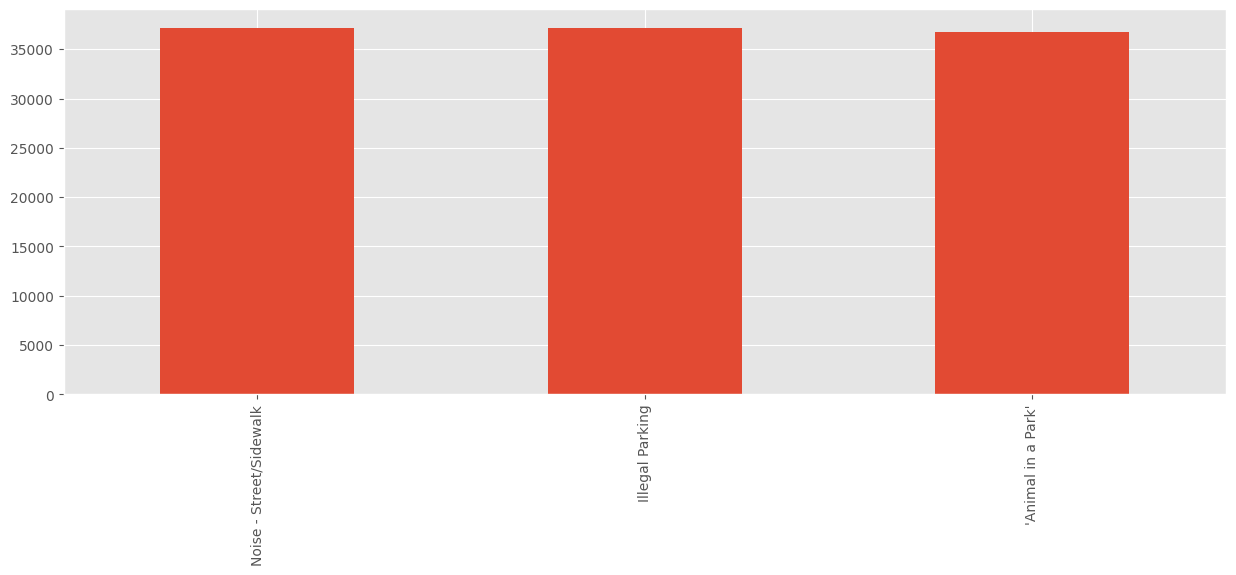

In [31]:
complaint_counts[:10].plot(kind='bar')

## Request real result

Now that we finished our analysis on the mock data, we can request this execution on the real data.

In [32]:
@sy.syft_function(input_policy=sy.ExactMatch(df=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(df):
    complaint_counts = df['Complaint Type'].value_counts()
    return complaint_counts[:10]

Request code execution

In [33]:
req = guest_domain_client.api.services.code.request_code_execution(get_counts)

In [34]:
submitted_code = guest_domain_client.code[0]

In [35]:
assert guest_domain_client.api.services.code.get_all()

Create and submit project

In [36]:
new_project = sy.Project(name="Pandas chapter 2",
                         description="Hi, I would like to plot the histogram of the complaint types.")

In [37]:
new_project.add_request(obj=submitted_code, permission=sy.UserCodeStatus.EXECUTE)

In [38]:
guest_domain_client.submit_project(new_project)

<class 'syft.service.response.SyftSuccess'>: Project Submitted

# Data owner: execute function

In [39]:
domain_client = node.client.login(email="info@openmined.org", password="changethis")

# Get messages

In [40]:
messages = domain_client.api.services.messages.get_all_for_status(sy.MessageStatus.UNDELIVERED)

In [41]:
messages

,type,id,subject,status,created_at,linked_obj
0,syft.service.message.messages.Message,c288cf3bbbba422f98a39b6d38df78ed,Project Approval,MessageStatus.UNDELIVERED,2023-05-16 11:49:34,<<class 'syft.service.project.project.Project'...
1,syft.service.message.messages.Message,274dd610a9554020aa55b4c45c7b8f6e,Approval Request,MessageStatus.UNDELIVERED,2023-05-16 11:49:33,<<class 'syft.service.request.request.Request'...


In [42]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [43]:
request = project_message.link.requests[0]
func = request.changes[0].link
op = func.output_policy_type

In [44]:
func

```python
class UserCode:
  id: str = 2b129a376476450a9e1862231a65e0c1
  node_uid: str = e6511c55456b4ad7844f04d2985660cb
  user_verify_key: str = d400b05c6aea1c1b6d3f1fbeb0c2d380153dd999a9c4b03e322faf5d6083563d
  raw_code: str = "@sy.syft_function(input_policy=sy.ExactMatch(df=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(df):
    complaint_counts = df['Complaint Type'].value_counts()
    return complaint_counts[:10]
"
  input_policy_type: str = <class 'syft.service.policy.policy.ExactMatch'>
  input_policy_init_kwargs: str = {NodeView(node_name='pandas-test-domain-1', verify_key=b234b52729d1809158ad0ab96c442650d215e39bcc7aaa27187acaff0f0350dc): {'df': <UID: b1ee16fcad0f4d06945039acd9ebf9d6>}}
  input_policy_state: str = b''
  output_policy_type: str = <class 'syft.service.policy.policy.OutputPolicyExecuteOnce'>
  output_policy_init_kwargs: str = {}
  output_policy_state: str = b''
  parsed_code: str = "def user_func_get_counts_d400b05c6aea1c1b6d3f1fbeb0c2d380153dd999a9c4b03e322faf5d6083563d_ced68a4f95bc589adb5d44379eadb950ec506fd867517162b08636312d78c3f6(df):

    def get_counts(df):
        complaint_counts = df['Complaint Type'].value_counts()
        return complaint_counts[:10]
    result = get_counts(df=df)
    return result"
  service_func_name: str = "get_counts"
  unique_func_name: str = "user_func_get_counts_d400b05c6aea1c1b6d3f1fbeb0c2d380153dd999a9c4b03e322faf5d6083563d_ced68a4f95bc589adb5d44379eadb950ec506fd867517162b08636312d78c3f6"
  user_unique_func_name: str = "user_func_get_counts_d400b05c6aea1c1b6d3f1fbeb0c2d380153dd999a9c4b03e322faf5d6083563d"
  code_hash: str = "ced68a4f95bc589adb5d44379eadb950ec506fd867517162b08636312d78c3f6"
  signature: str = (df)
  status: str = {NodeView(node_name='pandas-test-domain-1', verify_key=b234b52729d1809158ad0ab96c442650d215e39bcc7aaa27187acaff0f0350dc): <UserCodeStatus.SUBMITTED: 'submitted'>}
  input_kwargs: str = ['df']
  enclave_metadata: str = None

```

In [45]:
get_counts_user_func = func.unsafe_function

In [46]:
real_data = domain_client.datasets[0].assets[0].data

In [47]:
real_result = get_counts_user_func(df=real_data)

In [48]:
real_result[:3]

HEATING                   14200
GENERAL CONSTRUCTION       7471
Street Light Condition     7117
Name: Complaint Type, dtype: int64

In [49]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [50]:
asset = guest_client.datasets[0].assets[0]

In [51]:
guest_client.api.services.code[0].status

{NodeView(node_name='pandas-test-domain-1', verify_key=b234b52729d1809158ad0ab96c442650d215e39bcc7aaa27187acaff0f0350dc): <UserCodeStatus.EXECUTE: 'execute'>}

```python
Pointer
```
<Axes: >

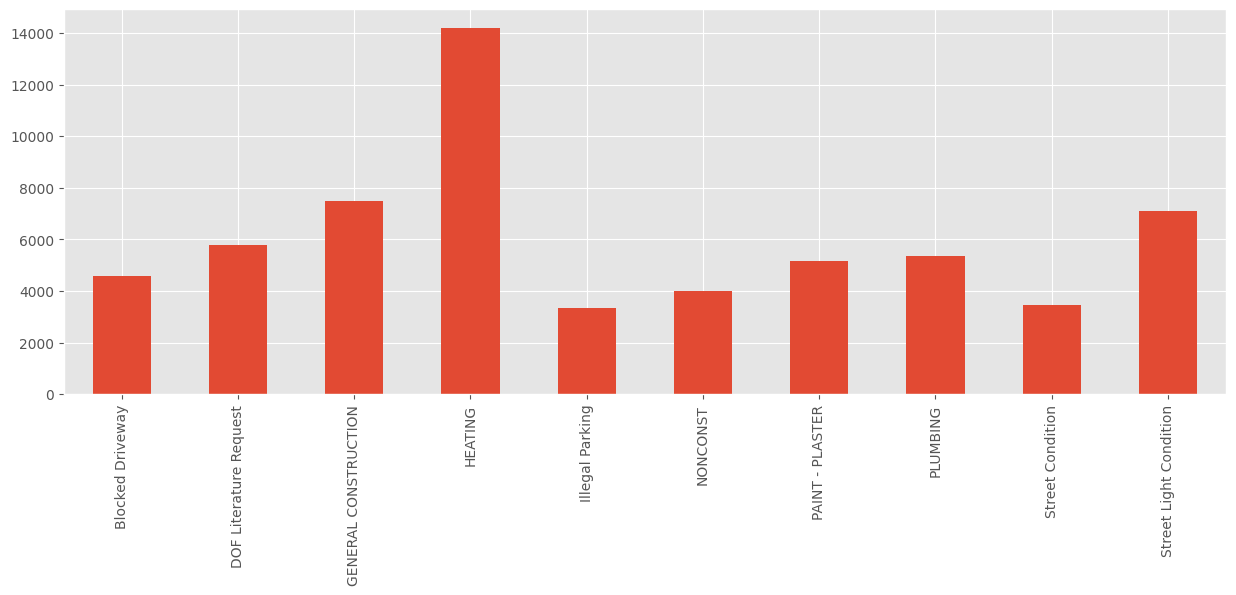

In [52]:
real_result = guest_client.api.services.code.get_counts(df=asset)
real_result.plot(kind="bar")

In [53]:
if node.node_type.value == "python":
    node.land()

Stopping pandas-test-domain-1
